In [114]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [9]:
cd USUKRUSITA_Files

/Users/isabella/Documents/GitHub/democracy/USUKRUSITA_Files


In [280]:
def get_cos_plot(country_name):
    """
    Return a plot three word lists' cosine
    similarity to democracy across all years, given a
    string of country abbreviation.
    """
    
    for aspect in ['econ', 'ide', 'gov']:
        # read csv
        econ = pd.read_csv('{}_cos_{}.csv'.format(aspect, country_name), index_col=0)
        # clean data
        econ = clean_df(econ, aspect)
        if aspect == 'econ':
            total = econ
        else:
            total[aspect] = econ[aspect]

    total = total.set_index('year')

    sns.set_style("darkgrid")
    g = sns.lineplot(data=total)
    g.figure.set_size_inches(10, 6)
    g.set_title('{}: Cosine Similiarty between Three Word List and Democracy'.format(country_name))

In [281]:
def clean_df(df, aspect):
    """
    A helper function that convert str values in a dataframe
    to float.
    """
    df['cosine_similarity']= df['cosine_similarity'].apply(lambda x: x[2:8])  
    df.replace("", 0, inplace=True)
    df['{}'.format(aspect)] = df['cosine_similarity'].astype('float')
    df = df.sort_values(by='year')
    if aspect != 'econ':
        df.drop(columns=['cosine_similarity', 'year'], inplace=True)
    else:
        df.drop(columns=['cosine_similarity'], inplace=True)
    return df

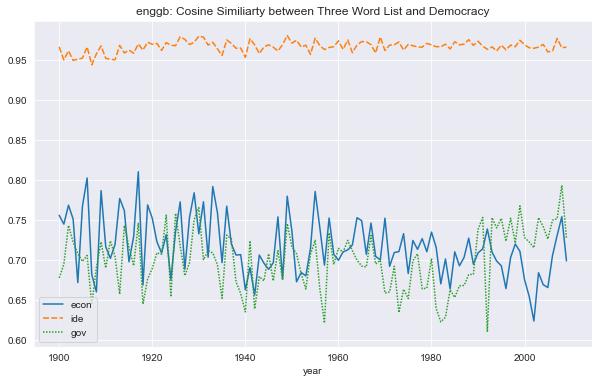

In [282]:
get_cos_plot('enggb')

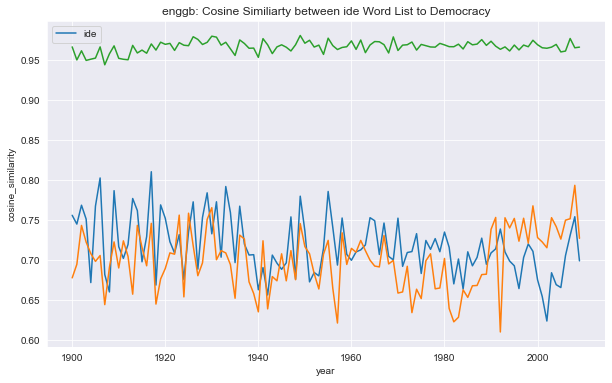

In [182]:
get_country_plots('eng')

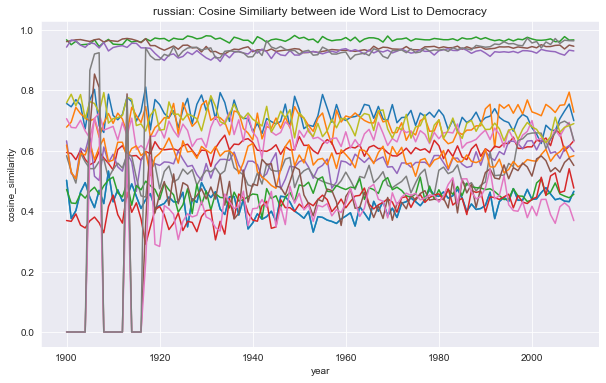

In [174]:
for country in [, 'engus', 'fre', 'ger', 'italian', 'russian']:
    get_country_plots(country)